Foursquare API keys and version

In [1]:
CLIENT_ID = 'redacted for github'
CLIENT_SECRET = 'redacted for github'
VERSION = '20180605'

imports

In [2]:
import pandas as pd
import numpy as np
import requests
import seaborn as sns
import matplotlib.pyplot as plt

set wiki page URL

In [3]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

read webpage and store as 'tables'

In [4]:
tables = pd.read_html(url, header=0)

since there are multiple tables, set a list of the headings of the table we're interested in

In [5]:
headings = ['Postcode', 'Borough', 'Neighbourhood']

loop over the tables in the webpage, and if the current table in the loop's headings match the headings we're interested in, we've found the table; thus exit the loop

In [6]:
for table in tables:
    current_headings = table.columns.values[:4]
    if all(current_headings == headings):
        break

filter out postcodes without boroughs

In [7]:
codes = table[table.Borough != 'Not assigned']

create a new dataframe grouping by postcode+borough combinations and aggregating neighborhoods into a comma-separated list

In [8]:
agg = codes.groupby(['Postcode', 'Borough'])['Neighbourhood'].apply(', '.join).to_frame()

reset the index of the aggregated dataframe and save it to a new dataframe

In [9]:
agg2 = agg.reset_index()

##### note
I abaonded geocoder because Anaconda couldn't install it correctly

set URL of lat/lon data

In [10]:
backup_url = 'http://cocl.us/Geospatial_data'

read file and store lat/lon data as 'geo_data'

In [11]:
geo_data = pd.read_csv(backup_url)

add the latitude and longitude columns to the aggregated and indexed dataframe

In [12]:
agg2['Latitude'] = geo_data['Latitude']
agg2['Longitude'] = geo_data['Longitude']

set search radius (in meters) and response limit for the Foursquare API call

note that the radius was increased from 500 to 1000 because the example neighborhood I tried exploring didn't return any venues with a 500 meter radius

In [13]:
radius = 1000
limit = 100

https://api.foursquare.com/v2/venues/explore?&client_id=CMDWUEBIIFYJ3WPZXIPUTNTLBP54S1QYEYBOFZWFSVFH5M0H&client_secret=FI2IYYDBNO1KRMDFNOEIO2RK5LQV2KSR2QPFUHOHLZ5O15DN&v=20180605&ll=43.79,-79.20&radius=500&limit=100

https://api.foursquare.com/v2/venues/542858a0498e22b7cfa91070/likes?client_id=CMDWUEBIIFYJ3WPZXIPUTNTLBP54S1QYEYBOFZWFSVFH5M0H&client_secret=FI2IYYDBNO1KRMDFNOEIO2RK5LQV2KSR2QPFUHOHLZ5O15DN&v=20200303

define a function to make the Foursquare API calls for each postcode in the dataframe

In [14]:
def getVenues(names, latitudes, longitudes):
    
    venues_list = []
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            lng,
            radius,
            limit)
        
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        venues_list.append([(
            name,
            lat,
            lng,
            v['venue']['name'],
            v['venue']['location']['lat'],
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name'],
            v['venue']['id']) for v in results])
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = [
            'Neighborhood',
            'Neighborhood latitude',
            'Neighborhood longitude',
            'Venue',
            'Venue latitude',
            'Venue longitude',
            'Venue category',
            'Venue ID']
        
    return(nearby_venues)

invoke the Foursquare API call function for each row in agg2, the dataframe of postcode+borough combinations

In [15]:
toronto_venues = getVenues(names=agg2['Neighbourhood'],
                          latitudes=agg2['Latitude'],
                          longitudes=agg2['Longitude'])

Rouge, Malvern
Highland Creek, Rouge Hill, Port Union
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
East Birchmount Park, Ionview, Kennedy Park
Clairlea, Golden Mile, Oakridge
Cliffcrest, Cliffside, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Scarborough Town Centre, Wexford Heights
Maryvale, Wexford
Agincourt
Clarks Corners, Sullivan, Tam O'Shanter
Agincourt North, L'Amoreaux East, Milliken, Steeles East
L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
Silver Hills, York Mills
Newtonbrook, Willowdale
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Flemingdon Park, Don Mills South
Bathurst Manor, Downsview North, Wilson Heights
Northwood Park, York University
CFB Toronto, Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Woodbine Gardens, Parkview Hill
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
The Danforth West, 

In [16]:
toronto_venues

,Neighborhood,Neighborhood latitude,Neighborhood longitude,Venue,Venue latitude,Venue longitude,Venue category,Venue ID
0,"Rouge, Malvern",43.806686,-79.194353,Wendy's,43.802008,-79.198080,Fast Food Restaurant,579a91b3498e9bd833afa78a
1,"Rouge, Malvern",43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant,4bb6b9446edc76b0d771311c
2,"Rouge, Malvern",43.806686,-79.194353,Harvey's,43.800020,-79.198307,Restaurant,4b6718c2f964a5203f3a2be3
3,"Rouge, Malvern",43.806686,-79.194353,Caribbean Wave,43.798558,-79.195777,Caribbean Restaurant,4b914562f964a520d4ae33e3
4,"Rouge, Malvern",43.806686,-79.194353,Staples Morningside,43.800285,-79.196607,Paper / Office Supplies Store,4bcb612d3740b713f0606265
...,...,...,...,...,...,...,...,...
4899,"Albion Gardens, Beaumond Heights, Humbergate, ...",43.739416,-79.588437,46 Martingrove North,43.732211,-79.589618,Bus Line,4c6fbf3234443704ebda215f
4900,"Albion Gardens, Beaumond Heights, Humbergate, ...",43.739416,-79.588437,Panorama Park,43.747021,-79.583497,Park,4ddec726d22d28453ec7cb33
4901,Northwest,43.706748,-79.594054,Tim Hortons,43.714657,-79.593716,Coffee Shop,4be452122457a593c40eaa15
4902,Northwest,43.706748,-79.594054,Economy Rent A Car,43.708471,-79.589943,Rental Car Location,5273f6f311d2137549494e29


create a dataframe of just venue IDs and neighborhoods

this will be the basis of finding the number of likes per neighborhood since likes are an attribute of each venue

In [17]:
venue_ids = toronto_venues[['Venue ID','Neighborhood']]

,Venue ID,Neighborhood
0,579a91b3498e9bd833afa78a,"Rouge, Malvern"
1,4bb6b9446edc76b0d771311c,"Rouge, Malvern"
2,4b6718c2f964a5203f3a2be3,"Rouge, Malvern"
3,4b914562f964a520d4ae33e3,"Rouge, Malvern"
4,4bcb612d3740b713f0606265,"Rouge, Malvern"
...,...,...
4899,4c6fbf3234443704ebda215f,"Albion Gardens, Beaumond Heights, Humbergate, ..."
4900,4ddec726d22d28453ec7cb33,"Albion Gardens, Beaumond Heights, Humbergate, ..."
4901,4be452122457a593c40eaa15,Northwest
4902,5273f6f311d2137549494e29,Northwest


one-hot encode the venue values

In [18]:
onehot = pd.get_dummies(toronto_venues[['Venue category']], prefix='', prefix_sep='')
onehot['Neighborhood'] = toronto_venues['Neighborhood']
onehot['Venue ID '] = toronto_venues['Venue ID']
fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])
onehot = onehot[fixed_columns]

In [19]:
onehot

,Venue ID,Accessories Store,Afghan Restaurant,Airport,Airport Lounge,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,...,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
0,579a91b3498e9bd833afa78a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4bb6b9446edc76b0d771311c,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4b6718c2f964a5203f3a2be3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4b914562f964a520d4ae33e3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4bcb612d3740b713f0606265,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4899,4c6fbf3234443704ebda215f,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4900,4ddec726d22d28453ec7cb33,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4901,4be452122457a593c40eaa15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4902,5273f6f311d2137549494e29,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


group the results by neighborhood and take the mean of component one-hot encoded venue categories to measure how frequently each venue type appears in each neighborhood

the column named "Pizza Place" is essentially a score of how saturated a neighborhood is with regard to pizza restaurants

a high score incidates saturation (many pizza restaurants) and a zero or low score indicates a good candidate neighborhood (few or no pizza restaurants)

In [20]:
grouped = onehot.groupby('Neighborhood').mean().reset_index()
grouped.head()

,Neighborhood,Accessories Store,Afghan Restaurant,Airport,Airport Lounge,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,...,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
0,"Adelaide, King, Richmond",0.0,0.0,0.0,0.0,0.02,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0
1,Agincourt,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.021739,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
2,"Agincourt North, L'Amoreaux East, Milliken, St...",0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
4,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0


create a new dataframe from only the pizza place score column

In [21]:
pizza = grouped[['Neighborhood', 'Pizza Place']]

show the top ten pizza restaurant-saturated neighborhoods

In [22]:
pizza.sort_values('Pizza Place',ascending=False).head(10)

,Neighborhood,Pizza Place
25,"Cliffcrest, Cliffside, Scarborough Village West",0.250000
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",0.187500
94,Westmount,0.176471
38,Downsview West,0.142857
26,"Cloverdale, Islington, Martin Grove, Princess ...",0.142857
48,"Guildwood, Morningside, West Hill",0.120000
99,"Woodbine Gardens, Parkview Hill",0.095238
72,"Northwood Park, York University",0.095238
97,Willowdale West,0.090909
39,"Downsview, North Park, Upwood Park",0.090909


see if any neighborhoods have a pizza place score of zero

In [24]:
pizza[pizza['Pizza Place'] == 0]

,Neighborhood,Pizza Place
6,Bayview Village,0.0
9,"Birch Cliff, Cliffside West",0.0
11,"Brockton, Exhibition Place, Parkdale Village",0.0
13,"CFB Toronto, Downsview East",0.0
14,"CN Tower, Bathurst Quay, Island airport, Harbo...",0.0
15,"Cabbagetown, St. James Town",0.0
31,"Del Ray, Keelesdale, Mount Dennis, Silverthorn",0.0
36,Downsview Central,0.0
42,"Emery, Humberlea",0.0
45,"Flemingdon Park, Don Mills South",0.0


In [49]:
len(pizza[pizza['Pizza Place'] == 0])

25

there are 25, so put those neighborhoods in a candidate neighborhoods list

In [23]:
candidates = pizza.sort_values('Pizza Place',ascending=True).head(25)['Neighborhood']
candidates

101                                      York Mills West
42                                      Emery, Humberlea
45                      Flemingdon Park, Don Mills South
53                Highland Creek, Rouge Hill, Port Union
56     Humber Bay, King's Mill Park, Kingsway Park So...
57                                         Humber Summit
59                                      Islington Avenue
61     Kingsway Park South West, Mimico NW, The Queen...
63                      Lawrence Heights, Lawrence Manor
64                                         Lawrence Park
71                                             Northwest
15                           Cabbagetown, St. James Town
36                                     Downsview Central
14     CN Tower, Bathurst Quay, Island airport, Harbo...
76                                              Rosedale
11          Brockton, Exhibition Place, Parkdale Village
77                                              Roselawn
9                            Bi

recall that there is a dataframe of neighborhoods and the IDs of venues in each neighborhood

In [25]:
venue_ids

,Venue ID,Neighborhood
0,579a91b3498e9bd833afa78a,"Rouge, Malvern"
1,4bb6b9446edc76b0d771311c,"Rouge, Malvern"
2,4b6718c2f964a5203f3a2be3,"Rouge, Malvern"
3,4b914562f964a520d4ae33e3,"Rouge, Malvern"
4,4bcb612d3740b713f0606265,"Rouge, Malvern"
...,...,...
4899,4c6fbf3234443704ebda215f,"Albion Gardens, Beaumond Heights, Humbergate, ..."
4900,4ddec726d22d28453ec7cb33,"Albion Gardens, Beaumond Heights, Humbergate, ..."
4901,4be452122457a593c40eaa15,Northwest
4902,5273f6f311d2137549494e29,Northwest


use .isin() to filter the venue list to only those venues in the candidate neighborhoods

In [26]:
candidate_venues = venue_ids[venue_ids['Neighborhood'].isin(candidates)]
candidate_venues

,Venue ID,Neighborhood
0,579a91b3498e9bd833afa78a,"Rouge, Malvern"
1,4bb6b9446edc76b0d771311c,"Rouge, Malvern"
2,4b6718c2f964a5203f3a2be3,"Rouge, Malvern"
3,4b914562f964a520d4ae33e3,"Rouge, Malvern"
4,4bcb612d3740b713f0606265,"Rouge, Malvern"
...,...,...
4835,4bd478387b1876b0520e8986,"Emery, Humberlea"
4836,5afb15856a5950002c61a9a3,"Emery, Humberlea"
4901,4be452122457a593c40eaa15,Northwest
4902,5273f6f311d2137549494e29,Northwest


here's an example API call to get the count of likes for a single venue

In [28]:
test_url = 'https://api.foursquare.com/v2/venues/579a91b3498e9bd833afa78a/likes?client_id=CMDWUEBIIFYJ3WPZXIPUTNTLBP54S1QYEYBOFZWFSVFH5M0H&client_secret=FI2IYYDBNO1KRMDFNOEIO2RK5LQV2KSR2QPFUHOHLZ5O15DN&v=20180605'
likes = requests.get(test_url).json()['response']['likes']['count']

In [29]:
likes

1

here's how to access each venues ID

In [30]:
candidate_venues

,Venue ID,Neighborhood
0,579a91b3498e9bd833afa78a,"Rouge, Malvern"
1,4bb6b9446edc76b0d771311c,"Rouge, Malvern"
2,4b6718c2f964a5203f3a2be3,"Rouge, Malvern"
3,4b914562f964a520d4ae33e3,"Rouge, Malvern"
4,4bcb612d3740b713f0606265,"Rouge, Malvern"
...,...,...
4835,4bd478387b1876b0520e8986,"Emery, Humberlea"
4836,5afb15856a5950002c61a9a3,"Emery, Humberlea"
4901,4be452122457a593c40eaa15,Northwest
4902,5273f6f311d2137549494e29,Northwest


In [31]:
candidate_venues.loc[0]['Venue ID']

'579a91b3498e9bd833afa78a'

initialize a list to collect what the Foursquare API will return for likes per venue

In [32]:
likes_list = []

loop over the candidate venues, call the API for likes, and store each venue's count of likes in the list

In [33]:
for index, row in candidate_venues.iterrows():
    #print(row['Venue ID'], row['Neighborhood'])
    url_id = row['Venue ID']
    url = 'https://api.foursquare.com/v2/venues/{}/likes?client_id={}&client_secret={}&v={}'.format(
        url_id,
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION)
    likes = requests.get(url).json()['response']['likes']['count']
    likes_list.append([row['Neighborhood'], row['Venue ID'], likes])

In [34]:
likes_list

[['Rouge, Malvern', '579a91b3498e9bd833afa78a', 1],
 ['Rouge, Malvern', '4bb6b9446edc76b0d771311c', 1],
 ['Rouge, Malvern', '4b6718c2f964a5203f3a2be3', 10],
 ['Rouge, Malvern', '4b914562f964a520d4ae33e3', 10],
 ['Rouge, Malvern', '4bcb612d3740b713f0606265', 6],
 ['Rouge, Malvern', '4b16e23bf964a520edbe23e3', 28],
 ['Rouge, Malvern', '4bd08ceeb221c9b6cbe8d3d0', 5],
 ['Rouge, Malvern', '4e25ba8fd164b6b74afdd029', 0],
 ['Rouge, Malvern', '4e0b137722713e13018e7117', 0],
 ['Rouge, Malvern', '4c61c478edd320a1835bab29', 1],
 ['Rouge, Malvern', '4e389459b61c438b547e8ed4', 0],
 ['Rouge, Malvern', '5561eacb498e09ff53b397ad', 0],
 ['Rouge, Malvern', '4c706524df6b8cfab244b84d', 1],
 ['Rouge, Malvern', '55e34982498ea9b7a8027f90', 1],
 ['Rouge, Malvern', '4b60878af964a520d9eb29e3', 2],
 ['Rouge, Malvern', '539641d9498ee4f723c48089', 4],
 ['Rouge, Malvern', '4bf01bf43a002d7f50ac85a4', 1],
 ['Rouge, Malvern', '4b89abadf964a520ae4a32e3', 3],
 ['Highland Creek, Rouge Hill, Port Union', '4b96e31cf964a520

In [35]:
type(likes_list)

list

make the likes list a dataframe

In [36]:
likes_frame = pd.DataFrame(likes_list)

In [37]:
likes_frame.columns=['Neighborhood', 'Venue ID', 'Likes']

In [38]:
likes_frame

,Neighborhood,Venue ID,Likes
0,"Rouge, Malvern",579a91b3498e9bd833afa78a,1
1,"Rouge, Malvern",4bb6b9446edc76b0d771311c,1
2,"Rouge, Malvern",4b6718c2f964a5203f3a2be3,10
3,"Rouge, Malvern",4b914562f964a520d4ae33e3,10
4,"Rouge, Malvern",4bcb612d3740b713f0606265,6
...,...,...,...
616,"Emery, Humberlea",4bd478387b1876b0520e8986,0
617,"Emery, Humberlea",5afb15856a5950002c61a9a3,0
618,Northwest,4be452122457a593c40eaa15,13
619,Northwest,5273f6f311d2137549494e29,0


sum likes by neighborhood and sort from most to least

In [39]:
neighborhood_likes = likes_frame.groupby(by='Neighborhood').sum().sort_values('Likes', ascending=False)
neighborhood_likes

,Likes
Neighborhood,
St. James Town,13782
"Brockton, Exhibition Place, Parkdale Village",4881
"Cabbagetown, St. James Town",1789
"Kingsway Park South West, Mimico NW, The Queensway West, Royal York South West, South of Bloor",1609
"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",1131
"Flemingdon Park, Don Mills South",1115
"Lawrence Heights, Lawrence Manor",553
Rosedale,482
Roselawn,261


plot the candidate neighborhoods' likes to visualize the distribution

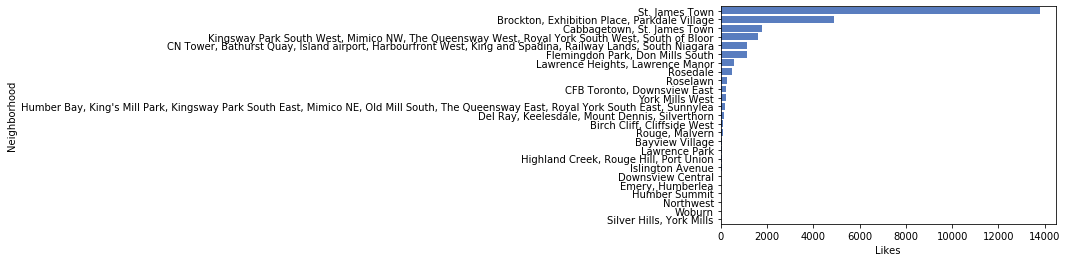

In [40]:
sns.set_color_codes('muted')
sns.barplot(y=neighborhood_likes.index, x=neighborhood_likes['Likes'], color='b')

note that the distribution is pretty skewed

so if likes are a measure of online exposure, some neighborhoods are getting drastically more online exposure (via Foursquare) than others

a scatterplot of all neighborhoods' likes vs pizza place score would be compelling, but not material to the decision this analysis is supporting (e.g. we are only considering neighborhoods with low pizza place scores, so there is no reason to plot all those since they have zero values)

recall that there is a dataframe of neighborhoods' pizza scores

In [41]:
pizza

,Neighborhood,Pizza Place
0,"Adelaide, King, Richmond",0.020000
1,Agincourt,0.021739
2,"Agincourt North, L'Amoreaux East, Milliken, St...",0.060606
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",0.187500
4,"Alderwood, Long Branch",0.071429
...,...,...
97,Willowdale West,0.090909
98,Woburn,0.000000
99,"Woodbine Gardens, Parkview Hill",0.095238
100,Woodbine Heights,0.066667


visualize the pizza scores of all the neighborhoods

In [42]:
pizza_chart = pizza.sort_values('Pizza Place', ascending=False)

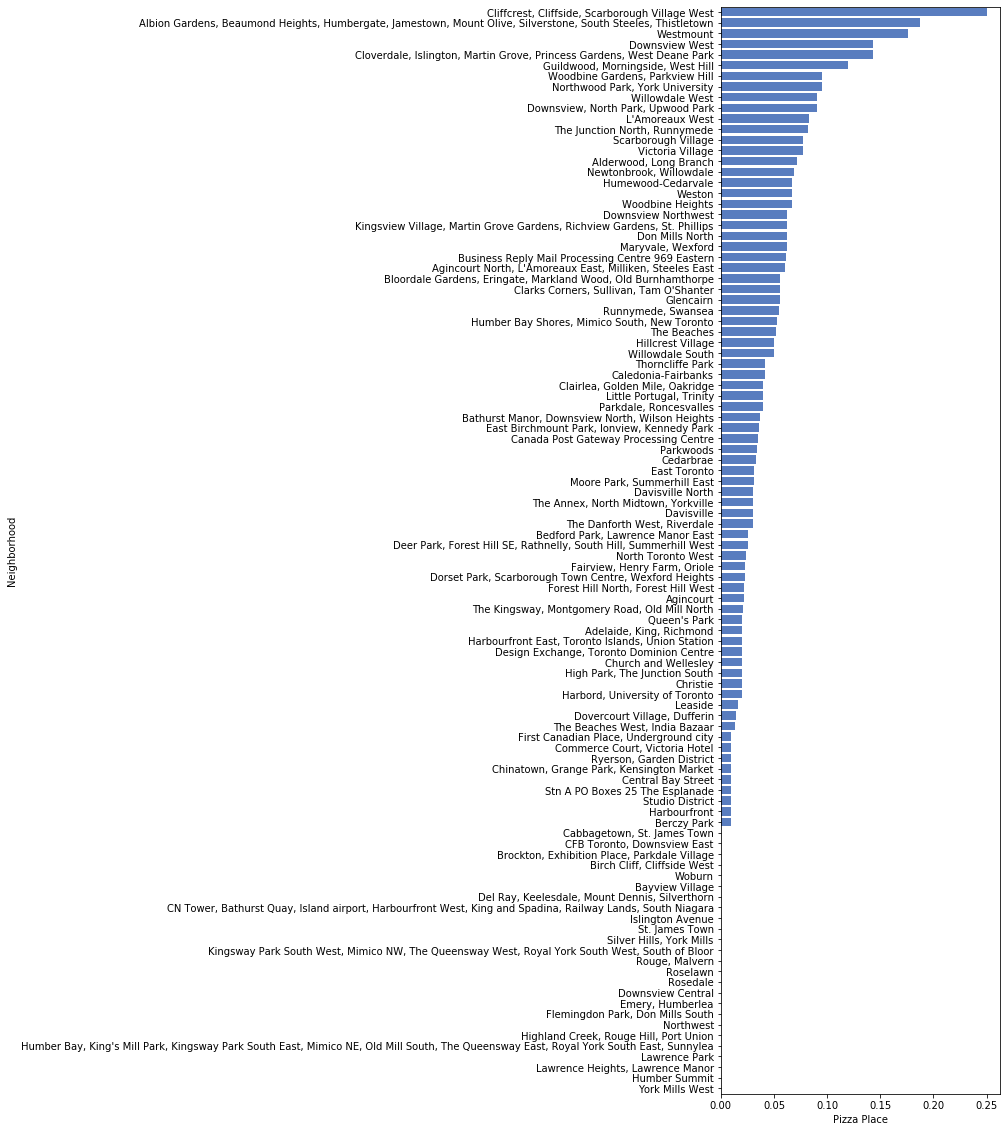

In [43]:
plt.figure(figsize=(5, 20))
sns.barplot(x=pizza_chart['Pizza Place'], y=pizza_chart['Neighborhood'], color='b')

note that the candidate neighborhoods with zero pizza place scores are at the bottom; the handful of neighborhoods at the top of the chart are very saturated

merge the likes and pizza score dataframes

In [44]:
pizza_join = pd.merge(pizza, neighborhood_likes, how='left', on='Neighborhood')
pizza_join

,Neighborhood,Pizza Place,Likes
0,"Adelaide, King, Richmond",0.020000,NaN
1,Agincourt,0.021739,NaN
2,"Agincourt North, L'Amoreaux East, Milliken, St...",0.060606,NaN
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",0.187500,NaN
4,"Alderwood, Long Branch",0.071429,NaN
...,...,...,...
97,Willowdale West,0.090909,NaN
98,Woburn,0.000000,13.0
99,"Woodbine Gardens, Parkview Hill",0.095238,NaN
100,Woodbine Heights,0.066667,NaN


drop the rows of neighborhoods that don't have likes values since they weren't sent to the API (they weren't in the candidate neighborhoods list)

In [45]:
pizza_final = pizza_join.dropna()
pizza_final

,Neighborhood,Pizza Place,Likes
6,Bayview Village,0.0,73.0
9,"Birch Cliff, Cliffside West",0.0,110.0
11,"Brockton, Exhibition Place, Parkdale Village",0.0,4881.0
13,"CFB Toronto, Downsview East",0.0,216.0
14,"CN Tower, Bathurst Quay, Island airport, Harbo...",0.0,1131.0
15,"Cabbagetown, St. James Town",0.0,1789.0
31,"Del Ray, Keelesdale, Mount Dennis, Silverthorn",0.0,118.0
36,Downsview Central,0.0,19.0
42,"Emery, Humberlea",0.0,16.0
45,"Flemingdon Park, Don Mills South",0.0,1115.0


display the top five neighborhoods with the most likes, and since these all have zero pizza places, this is the list to be recommended to the client

In [46]:
pizza_final.sort_values('Likes', ascending=False).head(5)

,Neighborhood,Pizza Place,Likes
83,St. James Town,0.0,13782.0
11,"Brockton, Exhibition Place, Parkdale Village",0.0,4881.0
15,"Cabbagetown, St. James Town",0.0,1789.0
61,"Kingsway Park South West, Mimico NW, The Queen...",0.0,1609.0
14,"CN Tower, Bathurst Quay, Island airport, Harbo...",0.0,1131.0
